In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import glob
import os

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='white'

In [4]:
!ls

Py_Pt_4GHz0deg_29dBm.txt    Py_Pt_4GHz265deg_29dBm.txt
Py_Pt_4GHz100deg_29dBm.txt  Py_Pt_4GHz270deg_29dBm.txt
Py_Pt_4GHz105deg_29dBm.txt  Py_Pt_4GHz275deg_29dBm.txt
Py_Pt_4GHz10deg_29dBm.txt   Py_Pt_4GHz280deg_29dBm.txt
Py_Pt_4GHz110deg_29dBm.txt  Py_Pt_4GHz285deg_29dBm.txt
Py_Pt_4GHz115deg_29dBm.txt  Py_Pt_4GHz290deg_29dBm.txt
Py_Pt_4GHz120deg_29dBm.txt  Py_Pt_4GHz295deg_29dBm.txt
Py_Pt_4GHz125deg_29dBm.txt  Py_Pt_4GHz300deg_29dBm.txt
Py_Pt_4GHz130deg_29dBm.txt  Py_Pt_4GHz305deg_29dBm.txt
Py_Pt_4GHz135deg_29dBm.txt  Py_Pt_4GHz30deg_29dBm.txt
Py_Pt_4GHz140deg_29dBm.txt  Py_Pt_4GHz310deg_29dBm.txt
Py_Pt_4GHz145deg_29dBm.txt  Py_Pt_4GHz315deg_29dBm.txt
Py_Pt_4GHz150deg_29dBm.txt  Py_Pt_4GHz320deg_29dBm.txt
Py_Pt_4GHz155deg_29dBm.txt  Py_Pt_4GHz325deg_29dBm.txt
Py_Pt_4GHz15deg_29dBm.txt   Py_Pt_4GHz330deg_29dBm.txt
Py_Pt_4GHz160deg_29dBm.txt  Py_Pt_4GHz335deg_29dBm.txt
Py_Pt_4GHz165deg_29dBm.txt  Py_Pt_4GHz340deg_29dBm.txt
Py_Pt_4GHz170deg_29dBm.txt  Py_Pt_4GHz345deg_29dBm.txt
Py_Pt_4GHz1

# Import data

In [5]:
all_files = glob.glob('*.txt')[:]; len(all_files)

74

In [6]:
def fun(s,i,end):
    try:
        return int(s[i:end])
    except ValueError:
        return fun(s,i+1,end)

Extract angles

In [7]:
angles = np.empty((0,0))
for file in all_files:
    if file.find('deg') != -1:
        angle = fun(file, file.find('deg')-3, file.find('deg'))
        if angle not in angles:
            angles = np.append(angles, angle)
angles.sort()

Arrange file names into a 2D array

In [8]:
files = [None]*len(angles)
for file in all_files:
    if file.find('29dBm') != -1:
        files[list(angles).index(fun(file, file.find('deg')-3, file.find('deg')))] = file

Load data

In [9]:
load = lambda x: pd.read_csv((x), header=1, sep="\t",
                             names = ['B_current', 'B', 'Vabs', 'Vishe', 'Vlockin', 'VRlockin', 'VThetalockin'])
dfs = [load(i) for i in files]

Drop rows containing missing values

In [10]:
dfs = [df.dropna(0) for df in dfs]

# Fit the signal and absorption

Define fitting functions

In [11]:
def fit_abs(x, *args):
    (M, M2, Bres, lwidth, off) = args;
    return (- 2*M*(x-Bres)*(0.5*lwidth)**2/((x-Bres)**2 + (0.5*lwidth)**2)**2
            - 2*M2*(0.5*lwidth)**2*((x-Bres)**2-(0.5*lwidth)**2)/(((x-Bres)**2 + (0.5*lwidth)**2)**2) + off)

In [12]:
def fit_ISHE(x, *args):
    (M, M2, Bres, lwidth, off) = args;
    return (M*(0.5*lwidth)**2/((x-Bres)**2 + (0.5*lwidth)**2)
            -M2*(x-Bres)*lwidth/((x-Bres)**2 + (0.5*lwidth)**2) + off)

Fit the ISHE voltage data

In [13]:
p1 = [1.0, 0.1, 17.0, 2, -0.1]    # initial arguments
params1 = np.empty((len(angles), 5))
params_covariance1 = np.empty((len(angles), 5))
for i in range(len(angles)):
    try:
        B = dfs[i].B*1000
        V = dfs[i].Vishe*1000000
        p1[0] = np.abs(V.min()-V.max())
        #p1[2] = B[(V-V.mean()).abs().idxmax()]
        p1[4] = V.mean()
        pars, parscov = scipy.optimize.curve_fit(fit_ISHE, B, V, p1)
        params1[i,:], params_covariance1[i,:] = pars, np.sqrt(np.diag(parscov))
    except RuntimeError:
        print('Runtime error in file: ', files[i])
    except:
        print(files[i])
        raise

Save fitting parameters

In [14]:
np.save('params1', params1)
np.save('params_covariance1', params_covariance1)

In [15]:
params1 = np.load('params1.npy')
params_covariance1 = np.load('params_covariance1.npy')

Fit the locked-in absorption data

In [16]:
p2 = [10, 1, 21.5, 2, -0.1]    # initial arguments
params2 = np.empty((len(angles), 5))
params_covariance2 = np.empty((len(angles), 5))
for i in range(len(angles)):
    try:
        B = dfs[i].B*1000
        V = dfs[i].Vlockin*1000000
        p2[0] = np.abs(V.min()-V.max())
        #p2[2] = (B[V.idxmax()] + B[V.idxmin()])/2
        p2[4] = V.mean()
        pars, parscov = scipy.optimize.curve_fit(fit_abs, B, V, p2)
        params2[i,:], params_covariance2[i,:] = pars, np.sqrt(np.diag(parscov))
    except RuntimeError:
        print('Runtime error in file: ', files[i])
    except:
        print(files[i])
        raise

Runtime error in file:  Py_Pt_4GHz90deg_29dBm.txt


/root/miniconda3/envs/cavendish/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Runtime error in file:  Py_Pt_4GHz270deg_29dBm.txt


Save fitting parameters

In [17]:
np.save('params2', params2)
np.save('params_covariance2', params_covariance2)

In [18]:
params2 = np.load('params2.npy')
params_covariance2 = np.load('params_covariance2.npy')

Plot data for 29dBm power

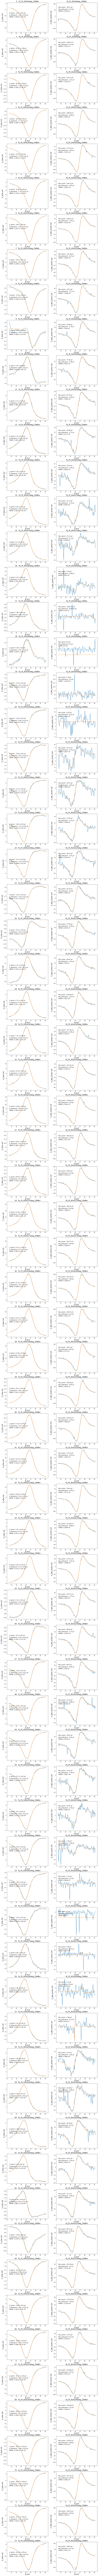

In [19]:
fig = plt.figure(figsize=(15,len(dfs)*6))
for i in range(len(dfs)):
    
    ax = fig.add_subplot(len(dfs),2,(2*i+1))
    ax.plot(dfs[i].B*1000, dfs[i].Vishe*1000000)
    ax.plot(dfs[i].B*1000, fit_ISHE(dfs[i].B*1000, *params1[i,:]))
    ax.set_xlabel('B /mT', fontsize=15)
    ax.set_ylabel('V_ishe /uV', fontsize=15)
    ax.set_title(str(i)+'   '+files[i][:-4], fontsize=15)
    ax.annotate(('V_symm: ' + str(round(params1[i,0], 2)) + ' $\pm$ ' + str(round(params_covariance1[i,0], 2))
                 + ' $\mu V$\nV_antisymm: ' + str(round(params1[i,1], 2)) + ' $\pm$ ' + str(round(params_covariance1[i,1], 2))
                 + ' $\mu V$\nFWHM: ' + str(round(params1[i,3], 4)) + ' $\pm$ ' + str(round(params_covariance1[i,3], 2))
                 + ' mT'), (0.05, 0.5), xycoords='axes fraction', fontsize=12)
    
    ax = fig.add_subplot(len(dfs),2,(2*i+2))
    ax.plot(dfs[i].B*1000, dfs[i].Vlockin*1000000)
    ax.plot(dfs[i].B*1000, fit_abs(dfs[i].B*1000, *params2[i,:]))
    ax.set_xlabel('B /mT', fontsize=15)
    ax.set_ylabel('V_abs_lockin /uV', fontsize=15)
    ax.set_title(files[i][:-4],fontsize=15)
    ax.annotate(('Res_symm: ' + str(round(params2[i,0], 2)) + ' $\mu V$' + '\nRes_antisymm: ' + str(round(params2[i,1], 2))
                 + ' $\mu V$\nFWHM: ' + str(round(params2[i,3], 4)) + ' mT'), (0.05, 0.7), xycoords='axes fraction', fontsize=12)
plt.show()

# Angular dependence plots and fits

In [20]:
def fit_ang_sym(angle, *args):
    (phy, Vamr_x, Vamr_z, Vahe, Vishe, ang_offset) = args
    return (-np.sin(phy)*Vamr_x*np.sin(np.pi/2+angle-ang_offset)*np.cos(2*(np.pi/2+angle-ang_offset))
            + np.sin(phy)*Vamr_z*np.sin(np.pi/2+angle-ang_offset)*np.sin(2*(np.pi/2+angle-ang_offset))
            - np.cos(phy)*Vahe*np.sin(np.pi/2+angle-ang_offset) + Vishe*(np.sin(np.pi/2+angle-ang_offset))**3)

def fit_ang_antisym(angle, *args):
    (phy, Vamr_x, Vamr_z, Vahe, Vishe, ang_offset) = args
    return (np.cos(phy)*Vamr_x*np.sin(np.pi/2+angle-ang_offset)*np.cos(2*(np.pi/2+angle-ang_offset))
            - np.cos(phy)*Vamr_z*np.sin(np.pi/2+angle-ang_offset)*np.sin(2*(np.pi/2+angle-ang_offset))
            - np.sin(phy)*Vahe*np.sin(np.pi/2+angle-ang_offset))

In [21]:
def fit_ang_total(angle_combo, *args):
    sym = fit_ang_sym(angle_combo[:len(angle_combo)//2], *args)
    antisym = fit_ang_antisym(angle_combo[len(angle_combo)//2:], *args)
    return np.append(sym, antisym)

In [22]:
angle_combo = np.append(angles/360*2*np.pi, angles/360*2*np.pi)
initials = np.array([90*np.pi/180, 0, 0.0, 0.0,  0.0, 0.0])
y_combo = np.append(params1[:,0], params1[:,1])

params_ang, params_ang_cov = scipy.optimize.curve_fit(fit_ang_total, angle_combo, y_combo, initials)
params_ang_cov = np.sqrt(np.diag(params_ang_cov))

Save fit

In [23]:
params_ang[0]/np.pi*180

101.50035861668972

In [24]:
np.save('params_ang', params_ang)

In [25]:
fit_sym = fit_ang_sym(angles/360*2*np.pi, *params_ang)
fit_antisym = fit_ang_antisym(angles/360*2*np.pi, *params_ang)

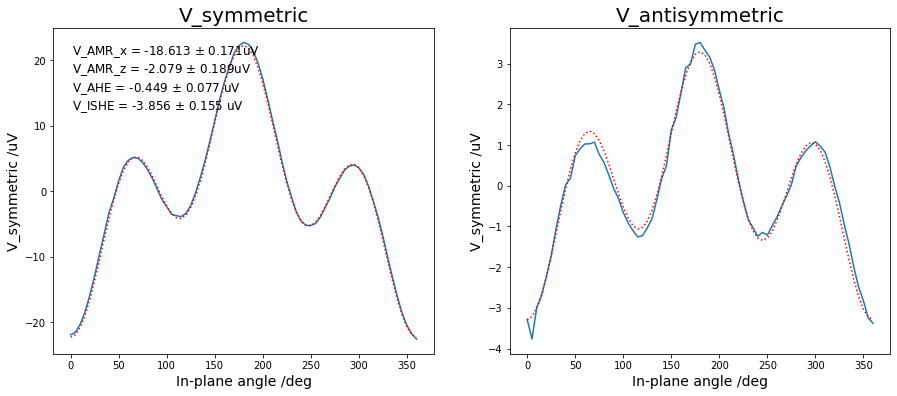

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.plot(angles, params1[:,0])
ax1.plot(angles, fit_sym, 'r:')
ax2.plot(angles, params1[:,1])
ax2.plot(angles, fit_antisym, 'r:')
ax1.set_title('V_symmetric', fontsize=20)
ax2.set_title('V_antisymmetric', fontsize=20)
ax1.set_xlabel('In-plane angle /deg', fontsize=14)
ax2.set_xlabel('In-plane angle /deg', fontsize=14)
ax1.set_ylabel('V_symmetric /uV', fontsize=14)
ax2.set_ylabel('V_symmetric /uV', fontsize=14)
ax1.annotate(('V_AMR_x = ' + str(round(params_ang[1],3)) + ' $\pm$ ' + str(round(params_ang_cov[1],3))
              + 'uV\nV_AMR_z = ' + str(round(params_ang[2],3)) + ' $\pm$ ' + str(round(params_ang_cov[2],3))
              + 'uV\nV_AHE = ' + str(round(params_ang[3],3)) + ' $\pm$ ' + str(round(params_ang_cov[3],3))
              + ' uV\nV_ISHE = ' + str(round(params_ang[4],3)) + ' $\pm$ ' + str(round(params_ang_cov[4],3))
              + ' uV'), (0.05, 0.75), xycoords='axes fraction', fontsize=12)

plt.savefig('In-plane_ang_dep.png')
plt.show()

Power absorption vs. angle

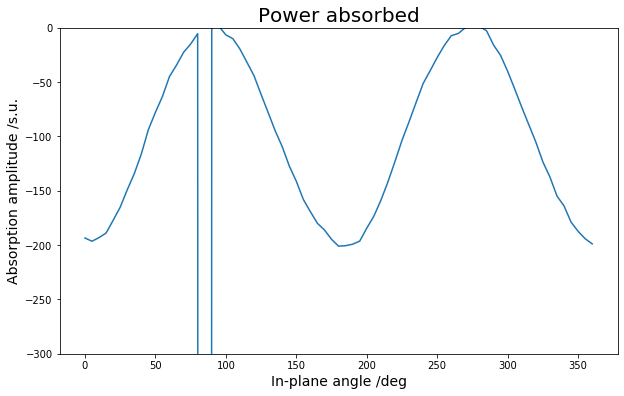

In [27]:
fig=plt.figure(figsize=(10,6))
plt.plot(angles, params2[:,0])
plt.title('Power absorbed', fontsize=20)
plt.xlabel('In-plane angle /deg', fontsize=14)
plt.ylabel('Absorption amplitude /s.u.', fontsize=14)
plt.ylim(-300, 0)
plt.show()